# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who voted whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
!pip install nltk

In [2]:
!pip install gensim

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [5]:
import kagglehub
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

100%|██████████| 242M/242M [00:09<00:00, 27.6MB/s]

Extracting files...


In [7]:
import os
con = sqlite3.connect(os.path.join(path, 'database.sqlite'))
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con)
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [9]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [11]:
display['COUNT(*)'].sum()

np.int64(393063)

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [13]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [15]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator>HelpfulnessDenominator
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


,count
Score,
1,7976
0,1588


Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
!pip install bs4

In [21]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# **REVIEWS**

In [24]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:02<00:00, 4282.71it/s]


In [25]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

#  Encoding


In [26]:
from gensim.models import Word2Vec


In [27]:
# Train Word2Vec model using text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [28]:
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

[('excellent', 0.8775844573974609), ('good', 0.8460702896118164), ('wonderful', 0.7742822170257568), ('quick', 0.7626125812530518), ('overall', 0.7520174980163574), ('speedy', 0.7332074046134949), ('amazing', 0.732643723487854), ('especially', 0.7301682829856873), ('exactly', 0.7266256213188171), ('tasty', 0.7244312167167664)]
[('hands', 0.9871401786804199), ('disappointing', 0.9807882905006409), ('jamaica', 0.9766491651535034), ('hooked', 0.9751899838447571), ('kona', 0.9711196422576904), ('absolute', 0.9709787964820862), ('lavazza', 0.9700285196304321), ('kcups', 0.9693870544433594), ('mediocre', 0.9692655801773071), ('consumed', 0.9687967896461487)]


In [29]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['not', 'like', 'good', 'great', 'taste', 'coffee', 'one', 'would', 'product', 'flavor', 'love', 'no', 'tea', 'food', 'really', 'get', 'much', 'use', 'best', 'time', 'amazon', 'also', 'tried', 'little', 'make', 'buy', 'price', 'find', 'well', 'better', 'try', 'even', 'cup', 'chips', 'bag', 'chocolate', 'sugar', 'water', 'eat', 'first', 'hot', 'could', 'drink', 'made', 'found', 'mix', 'used', 'bought', 'free', 'sweet']


In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 9564/9564 [00:17<00:00, 552.98it/s] 

9564
100


In [31]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 9564/9564 [02:53<00:00, 55.04it/s]


In [33]:
type(final)

pandas.core.frame.DataFrame

In [34]:
x=tfidf_sent_vectors
y=final['Score']

In [35]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

Accuracy: 0.8494773519163763


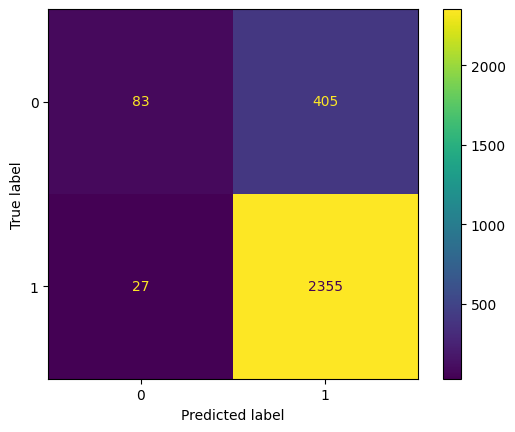

In [37]:
from sklearn.svm import LinearSVC
model_svm1 = LinearSVC(C=1.0, random_state=42)
model_svm1.fit(X_train, y_train)
y_pred_svm1 = model_svm1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm1))
ConfusionMatrixDisplay.from_estimator(model_svm1, X_test, y_test)
plt.show()

Accuracy: 0.8439024390243902


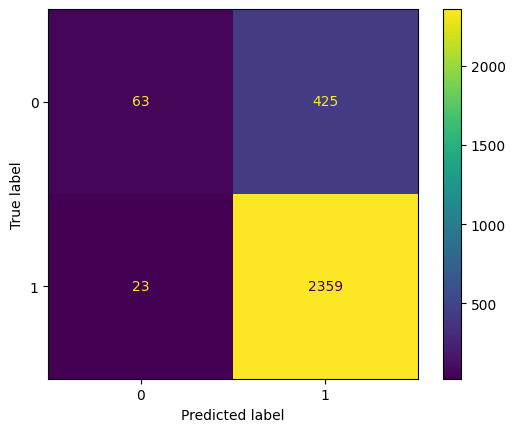

In [38]:
from sklearn.linear_model import LogisticRegression
model_lr1 = LogisticRegression()
model_lr1.fit(X_train, y_train)
y_pred1 =model_lr1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
ConfusionMatrixDisplay.from_estimator(model_lr1, X_test, y_test)
plt.show()

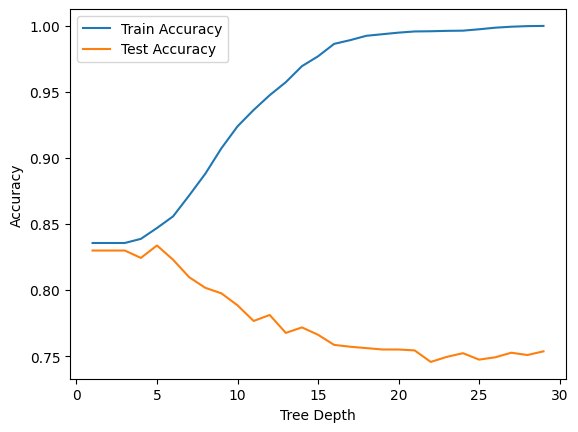

In [39]:
from sklearn.tree import DecisionTreeClassifier
train_acc, test_acc = [], []
for d in range(1, 30):
    model_dt1 = DecisionTreeClassifier(max_depth=d, random_state=42)
    model_dt1.fit(X_train, y_train)
    train_acc.append(model_dt1.score(X_train, y_train))
    test_acc.append(model_dt1.score(X_test, y_test))
plt.plot(range(1,30), train_acc, label='Train Accuracy')
plt.plot(range(1,30), test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth'); plt.ylabel('Accuracy'); plt.legend()
plt.show()



Accuracy: 0.824390243902439


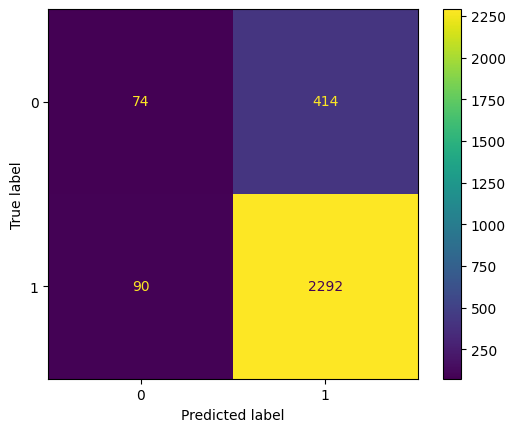

In [40]:
model_dt1 = DecisionTreeClassifier(max_depth=4, random_state=42)
model_dt1.fit(X_train, y_train)
y_pred_dt1 = model_dt1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt1))
ConfusionMatrixDisplay.from_estimator(model_dt1, X_test, y_test)
plt.show()


In [41]:
x2=sent_vectors
y2=final['Score']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x2,y2, test_size=0.3, random_state=42)

Accuracy: 0.8519163763066202


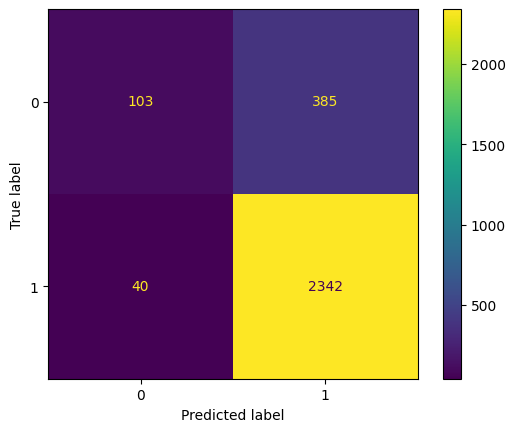

In [43]:
from sklearn.svm import LinearSVC
model_svm2 = LinearSVC(C=1.0, random_state=42)
model_svm2.fit(X_train, y_train)
y_pred_svm2 = model_svm2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm2))
ConfusionMatrixDisplay.from_estimator(model_svm2, X_test, y_test)
plt.show()

Accuracy: 0.8470383275261324


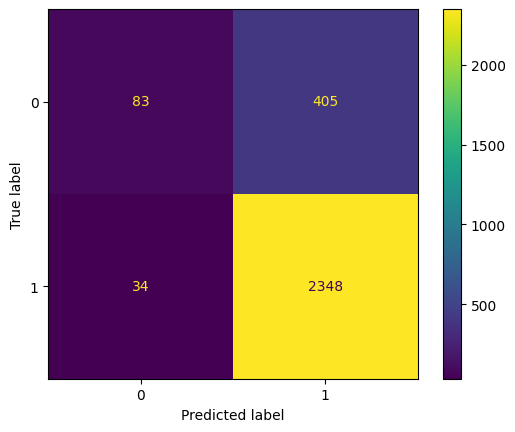

In [44]:

model_lr2 = LogisticRegression()
model_lr2.fit(X_train, y_train)
y_pred2 =model_lr2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred2))
ConfusionMatrixDisplay.from_estimator(model_lr2, X_test, y_test)
plt.show()


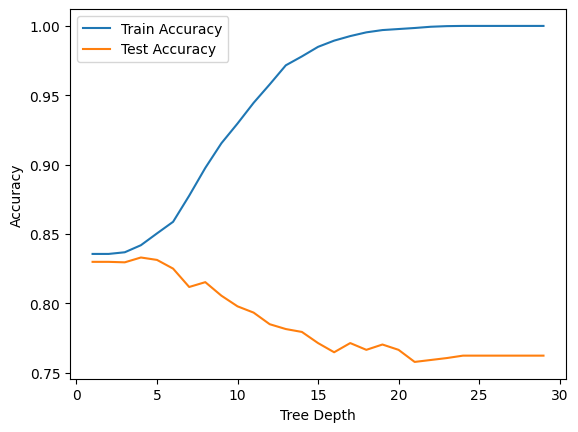

In [45]:
from sklearn.tree import DecisionTreeClassifier
train_acc, test_acc = [], []
for d in range(1, 30):
    model_dt2 = DecisionTreeClassifier(max_depth=d, random_state=42)
    model_dt2.fit(X_train, y_train)
    train_acc.append(model_dt2.score(X_train, y_train))
    test_acc.append(model_dt2.score(X_test, y_test))
plt.plot(range(1,30), train_acc, label='Train Accuracy')
plt.plot(range(1,30), test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth'); plt.ylabel('Accuracy'); plt.legend()
plt.show()


Accuracy: 0.8331010452961672


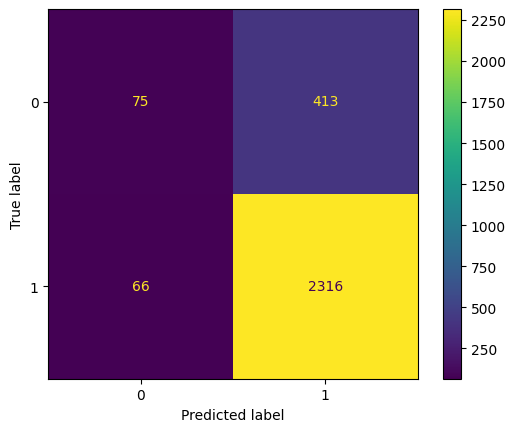

In [46]:
model_dt2 = DecisionTreeClassifier(max_depth=4, random_state=42)
model_dt2.fit(X_train, y_train)
y_pred_dt2 = model_dt2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt2))
ConfusionMatrixDisplay.from_estimator(model_dt2, X_test, y_test)
plt.show()

# **Summary**

In [47]:

from tqdm import tqdm
preprocessed_Summary = []

for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_Summary.append(sentance.strip())

100%|██████████| 9564/9564 [00:00<00:00, 14682.52it/s]


In [48]:
i=0
list_of_sentance2=[]
for sentance in preprocessed_Summary:
    list_of_sentance2.append(sentance.split())

In [49]:
want_to_train_w2v = True

if want_to_train_w2v:

    w2v_model2=Word2Vec(list_of_sentance2,min_count=5,vector_size=100, workers=4)
    print(w2v_model2.wv.most_similar('great'))
    print('='*50)
    print(w2v_model2.wv.most_similar('worst'))

[('not', 0.9991632103919983), ('good', 0.9991439580917358), ('flavor', 0.9990756511688232), ('best', 0.9990490674972534), ('no', 0.998873233795166), ('mix', 0.9988711476325989), ('better', 0.9988657832145691), ('low', 0.9988442063331604), ('delicious', 0.9988318681716919), ('tea', 0.998830258846283)]
[('best', 0.9939159750938416), ('good', 0.9936516880989075), ('perfect', 0.9936325550079346), ('low', 0.993596076965332), ('one', 0.9935490489006042), ('e', 0.9934819936752319), ('flavor', 0.9934437870979309), ('coffee', 0.9934242963790894), ('chips', 0.993421733379364), ('not', 0.9933108687400818)]


In [51]:
w2v_words2=list(w2v_model2.wv.index_to_key)

In [52]:
sent_vectors2 = [];
for sent in tqdm(list_of_sentance2):
    sent_vec2 = np.zeros(100)
    cnt_words2 =0;
    for word in sent:
        if word in w2v_words2:
            vec = w2v_model2.wv[word]
            sent_vec2 += vec
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors2.append(sent_vec2)
print(len(sent_vectors2))
print(len(sent_vectors2[0]))

100%|██████████| 9564/9564 [00:00<00:00, 20317.86it/s]

9564
100


In [53]:
x3=sent_vectors2
y3=final['Score']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x3,y3, test_size=0.3, random_state=42)

Accuracy: 0.8299651567944251


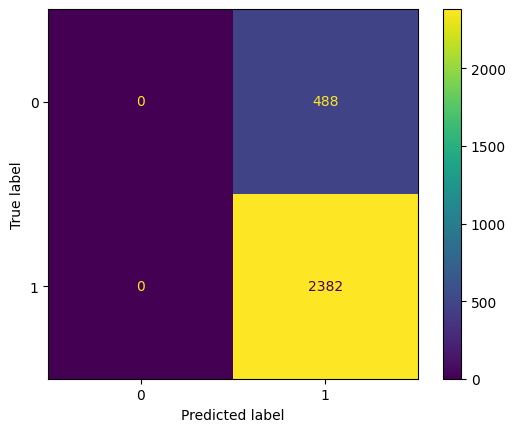

In [55]:
from sklearn.svm import LinearSVC
model_svm3 = LinearSVC(C=1.0, random_state=42)
model_svm3.fit(X_train, y_train)
y_pred_svm3 = model_svm3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm3))
ConfusionMatrixDisplay.from_estimator(model_svm3, X_test, y_test)
plt.show()

Accuracy: 0.8299651567944251


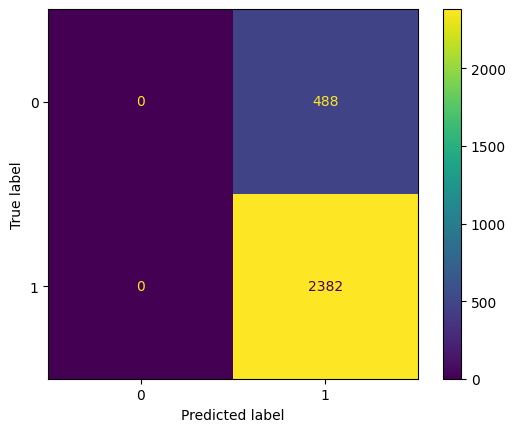

In [56]:
from sklearn.linear_model import LogisticRegression
model_lr3 = LogisticRegression()
model_lr3.fit(X_train, y_train)
y_pred3 =model_lr3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
ConfusionMatrixDisplay.from_estimator(model_lr3, X_test, y_test)
plt.show()

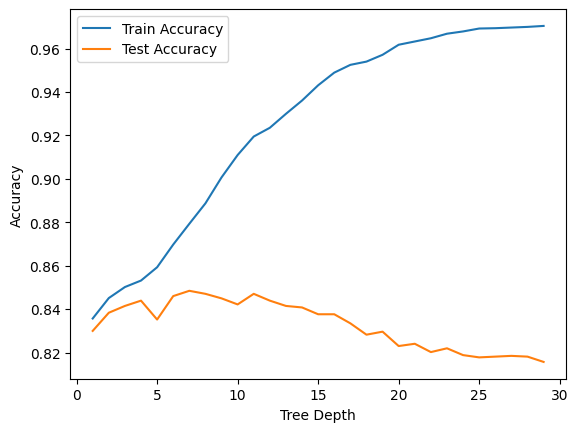

In [57]:
from sklearn.tree import DecisionTreeClassifier
train_acc, test_acc = [], []
for d in range(1, 30):
    model_dt3 = DecisionTreeClassifier(max_depth=d, random_state=42)
    model_dt3.fit(X_train, y_train)
    train_acc.append(model_dt3.score(X_train, y_train))
    test_acc.append(model_dt3.score(X_test, y_test))
plt.plot(range(1,30), train_acc, label='Train Accuracy')
plt.plot(range(1,30), test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth'); plt.ylabel('Accuracy'); plt.legend()
plt.show()

Accuracy: 0.845993031358885


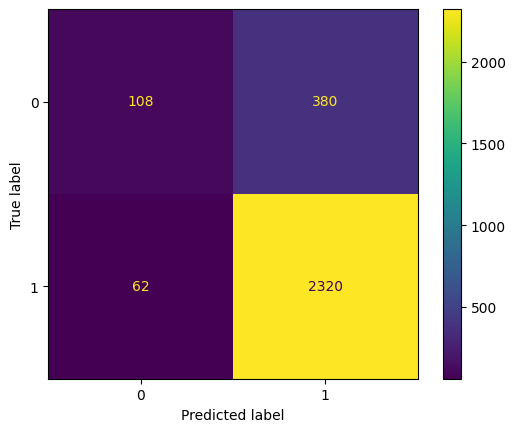

In [58]:
model_dt3 = DecisionTreeClassifier(max_depth=6, random_state=42)
model_dt3.fit(X_train, y_train)
y_pred_dt3 = model_dt3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt3))
ConfusionMatrixDisplay.from_estimator(model_dt3, X_test, y_test)
plt.show()

In [59]:
model2=TfidfVectorizer()
model2.fit(preprocessed_Summary)
dictionary2=dict(zip(model2.get_feature_names_out(),list(model2.idf_)))

In [60]:
tfidf_f=model2.get_feature_names_out()
tfidf_sv=[];
row=0;
for sent in tqdm(list_of_sentance2):
    sv=np.zeros(100)
    weight_sum=0
    for word in sent:
        if word in w2v_words2 and word in tfidf_f:
            vec=w2v_model2.wv[word]
            tfidf=dictionary2[word]*(sent.count(word)/len(sent))
            sv+=(vec*tfidf)
            weight_sum+=tfidf
    if weight_sum!=0:
        sv/=weight_sum
    tfidf_sv.append(sv)
    row+=1




100%|██████████| 9564/9564 [00:03<00:00, 2778.31it/s]


In [61]:
x4=tfidf_sv
y4=final['Score']

In [62]:
X_train,X_test,y_train,y_test=train_test_split(x4,y4,test_size=0.3,random_state=42)

accuracy: 0.8299651567944251


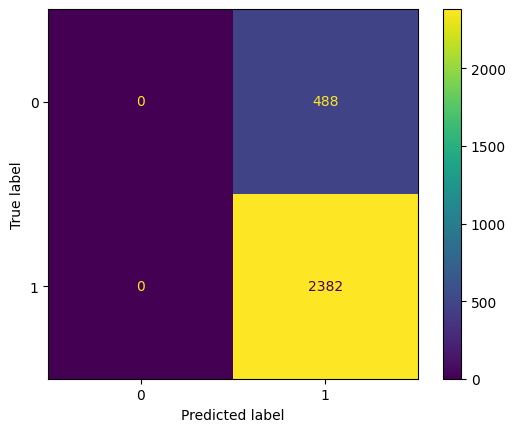

In [63]:
model_svm4=LinearSVC(C=1.0,random_state=42)
model_svm4.fit(X_train,y_train)
y_pred_svm4=model_svm4.predict(X_test)
accuracy=accuracy_score(y_test,y_pred_svm4)
print('accuracy:',accuracy)
ConfusionMatrixDisplay.from_estimator(model_svm4,X_test,y_test)
plt.show()

accuracy: 0.8299651567944251


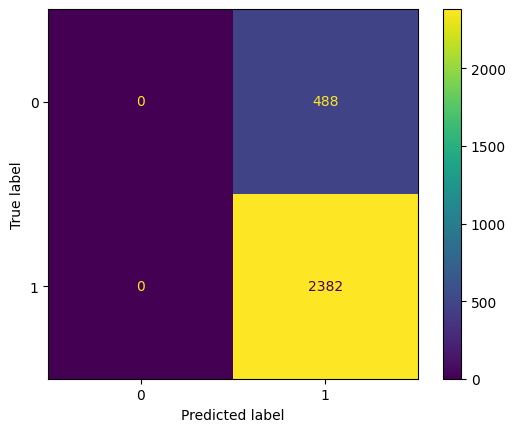

In [64]:
model_lr4=LogisticRegression()
model_lr4.fit(X_train,y_train)
y_pred4=model_lr4.predict(X_test)
accuracy=accuracy_score(y_test,y_pred4)
print('accuracy:',accuracy)
ConfusionMatrixDisplay.from_estimator(model_lr4,X_test,y_test)
plt.show()

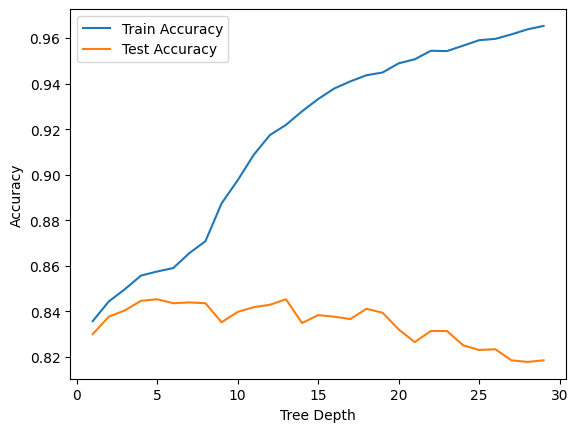

In [65]:
train_acc, test_acc = [], []
for d in range(1, 30):
    model_dt4 = DecisionTreeClassifier(max_depth=d, random_state=42)
    model_dt4.fit(X_train, y_train)
    train_acc.append(model_dt4.score(X_train, y_train))
    test_acc.append(model_dt4.score(X_test, y_test))
plt.plot(range(1,30), train_acc, label='Train Accuracy')
plt.plot(range(1,30), test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth'); plt.ylabel('Accuracy'); plt.legend()
plt.show()

Accuracy: 0.8435540069686411


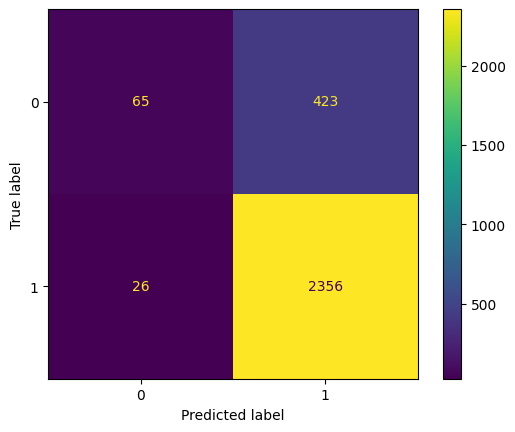

In [66]:
model_dt4 = DecisionTreeClassifier(max_depth=6, random_state=42)
model_dt4.fit(X_train, y_train)
y_pred_dt4 = model_dt4.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt4))
ConfusionMatrixDisplay.from_estimator(model_dt4, X_test, y_test)
plt.show()

The svm model(model_svm2) obtained after doing average Word2Vec method on the 'Text' of Reviews is most accurate machine learning model to determine a review is positive or negative. Accuracy is 0.8519163763066202

# **Checkig**

In [67]:
def predict_review_sentiment(user_review, w2v_model, svm_model):
    review = BeautifulSoup(user_review, 'html.parser').get_text()
    review = decontracted(review)
    review = re.sub("\S*\d\S*", "", review).strip()
    review = re.sub('[^A-Za-z]+', ' ', review)
    review_words = [word.lower() for word in review.split() if word.lower() not in stopwords]

    sent_vec = np.zeros(100)
    cnt_words = 0
    w2v_words = list(w2v_model.wv.index_to_key)

    for word in review_words:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1

    if cnt_words != 0:
        sent_vec /= cnt_words

    prediction = model_svm2.predict(sent_vec.reshape(1, -1))

    return "Positive" if prediction[0] == 1 else "Negative"


In [70]:
test_review = "This food is delicious"
result = predict_review_sentiment(test_review, w2v_model, model_svm2)
print(f"Review Sentiment: {result}")

Review Sentiment: Positive


In [71]:
import joblib
joblib.dump(model_svm2, 'svm_sentiment_model.pkl')
w2v_model.save("word2vec_model.bin")